In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import re
import ast
import matplotlib.pyplot as plt


In [4]:
class ProductCategorizer:
    def __init__(self):
        self.categories = {
            'Tablet': {
                'brands': ['ipad'],
                'identifiers': ['tablet']
            },
            'Smartphone': {
                'brands': ['iphone', 'huawei', 'xiaomi'],
                'identifiers': ['galaxy', 'smartphone', 'phone']
            },
            'Consola': {
                'brands': ['sony', 'xbox'],
                'identifiers': ['ps4', 'ps5', 'xbox one']
            },
            'Computador': {
                'brands': ['macbook', 'asus', 'lenovo', 'hp', 'dell', 'microsoft', 'acer'],
                'identifiers': ['laptop', 'notebook', 'pc', 'portatil', 'gaming']
            },
            'Acessorios': {
                'items': ['capa', 'carregador', 'fones', 'fone', 'película', 'pelicula', 
                         'protetor', 'volante', 'comando', 'auricular', 'cabo']
            },
            'Eletrodomesticos': {
                'brands': ['samsung', 'lg', 'whirlpool', 'bosch', 'siemens', 'electrolux', 'nespresso', 'delonghi', 'delta', 'krups'],
                'identifiers': ['frigorifico', 'maquina de lavar', 'maquina de secar', 'forno', 'microondas', 'maquina de cafe']
            },
        }
        
    def clean_text(self, text):
        """Limpa e normaliza o texto para melhor comparação"""
        text = text.lower()
        text = text.replace('ç', 'c').replace('ã', 'a').replace('õ', 'o')
        return text
    
    def is_accessory_for_brand(self, title):
        """Verifica se é um acessório específico para alguma marca"""
        clean_title = self.clean_text(title)
        
        is_accessory = any(acc in clean_title for acc in self.categories['Acessorios']['items'])
        
        if is_accessory:
            return True
        return False
    
    def categorize_product(self, title):
        """Categoriza um produto baseado no seu título"""
        clean_title = self.clean_text(title)
        
        if self.is_accessory_for_brand(title):
            return 'Acessorios'
        
        for category, rules in self.categories.items():
            if category == 'Acessorios':
                continue
                
            has_brand = any(brand in clean_title for brand in rules.get('brands', []))
            has_identifier = any(identifier in clean_title for identifier in rules.get('identifiers', []))
            
            if category == 'Smartphone':
                if 'galaxy' in clean_title or 'iphone' in clean_title:
                    return category
            
            if has_brand or has_identifier:
                return category
                
        return 'Outros' 

    def categorize_dataset(self, df):
        """Categoriza um DataFrame inteiro"""
        df['categoria'] = df['title'].apply(self.categorize_product)
        return df



In [5]:
categorizer = ProductCategorizer()

data = {
    'site': ['www.fnac.pt'] * 11,
    'date': ['20191118'] * 11,
    'title': [
        'Samsung Galaxy S10e G970FZ Verde',
        'Samsung Galaxy S10e G970FZ Amarelo',
        'Smartphone Samsung Galaxy S10E " 128Gb Branco',
        'iphone 11 pro max 256gb',
        'Huawei P30 Pro 8GB/256GB Dual Sim Aurora',
        'Capa Samsung Silicone para Galaxy S10+ Preto',
        'Capa Samsung Led View para Galaxy S10+ Preto',
        'MacBook Pro 13" 2020',
        'Capa Samsung Silicone para Galaxy S10+ Verde',
        'ipad pro 12.9 2020',
        'nespresso inissia',
    ]
}

df = pd.DataFrame(data)
df_categorized = categorizer.categorize_dataset(df)
print(df_categorized[['title', 'categoria']])


                                            title         categoria
0                Samsung Galaxy S10e G970FZ Verde        Smartphone
1              Samsung Galaxy S10e G970FZ Amarelo        Smartphone
2   Smartphone Samsung Galaxy S10E " 128Gb Branco        Smartphone
3                         iphone 11 pro max 256gb        Smartphone
4        Huawei P30 Pro 8GB/256GB Dual Sim Aurora        Smartphone
5    Capa Samsung Silicone para Galaxy S10+ Preto        Acessorios
6    Capa Samsung Led View para Galaxy S10+ Preto        Acessorios
7                            MacBook Pro 13" 2020        Computador
8    Capa Samsung Silicone para Galaxy S10+ Verde        Acessorios
9                              ipad pro 12.9 2020            Tablet
10                              nespresso inissia  Eletrodomesticos


In [11]:
df = pd.read_csv("all_prices_extracted_cleaned.csv")
print(df.shape)
df = df.dropna(subset=['title'])
print(df.shape) 
categorizer = ProductCategorizer()
df_categorized = categorizer.categorize_dataset(df)
df_categorized.to_csv("all_prices_extracted_cleaned_categorized.csv", index=False)

(925, 5)
(924, 5)


NameError: name 'ProductCategorizer' is not defined

___________________________________________________________________________________________________________________________________________



Quero extrair informações em diferentes níveis:

- Categoria - ja existe
- Marca tenho extrair do titulo
- Modelo (com detalhes específicos por marca)
- Site
- Promoção


Para cada nível, analisa:

Distribuição de produtos
Preços médios
Características específicas
Relações entre níveis
....



___________________________________________________________________________________________________________________________________________

In [18]:
class ProductAnalyzer:
    def __init__(self):
        self.brand_patterns = { 
            'hp': r'hp|omen by hp|pavilion', 
            'msi': r'msi', 
            'samsung': r'samsung|galaxy|note|galaxy\s*d+|galaxy\s*a\d+', 
            'apple': r'apple|iphone|ipad|macbook|mac|apple\sair', 
            'huawei': r'huawei|huawei\s*p\d+|mate\s?\d+', 
            'sony': r'sony|playstation|ps[0-9]', 
            'xiaomi': r'xiaomi|mi\s|redmi', 
            'asus': r'asus|rog|zenfone|zenbook|tuf|vivobook', 
            'lenovo': r'lenovo|thinkpad|ideapad|lenovo\slegion|yoga', 
            'dell': r'dell|inspiron|xps|latitude|alienware',
            'acer': r'acer|aspire|predator|nitro|swift', 
            'lg': r'lg|gram|v\d+|k\d+', 
            'motorola': r'motorola|motos\s|\sg\d+|\sz\d+', 
            'oneplus': r'oneplus|1\+\d+', 
            'google': r'google|pixel', 
            'microsoft': r'microsoft|surface', 
            'razer': r'razer|blade',
            'xbox' : r'xbox|series\s?x|series\s?s|xbox\sone|xbox\s360',
            'tcl' : r'tcl',
            'jbl' : r'jbl',
            'logitech' : r'logitech',
            'delonghi' : r'delonghi',
            'philips' : r'philips',
            'delta' : r'delta|delta\sq',
            'krups' : r'krups',
            'oppo' : r'oppo',
        }

        self.model_patterns = {
            'delonghi': {
            'essenza': r'essenza',
            'en': r'en\s*(\d+)',
            'inissia': r'inissia',
            'essenza_mini': r'essenza\s*mini',
            'lattissima': r'lattissima',
            },
            'delta' : {
            'q': r'qool | quick',
            },
            'krups' : {
            'essenza': r'essenza',
            'en': r'en\s*(\d+)',
            'inissia': r'inissia',
            'essenza_mini': r'essenza\s*mini',
            'lattissima': r'lattissima',
            'gusto': r'gusto',
            },
            'apple': {
            'iphone': r'iphone\s*(\d+|x\s|xr|xs|pro|max|mini|se)',
            'ipad': r'ipad\s*(\d+|pro|air|mini)',
            'macbook': r'macbook\s*(air|pro|12)',
            },
            'samsung': {
            'galaxy_s': r'galaxy\s?s(\d{1,2})',
            'galaxy_a': r'galaxy\s?a(\d{1,2})',
            },
            'huawei': {
            'p': r'p\s*(\d+)', 
            'mate': r'mate\s*(\d+)',
            'nova': r'nova\s*(\d+)',
            },
            'hp': {
            'omen': r'\s*omen\s*',
            'pavilion': r'pavilion\s*(\d+)|pavilion',
            'envy': r'envy\s*(\d+) | envy',
            'spectre': r'spectre\s*(\d+) | spectre',
            'stream' : r'stream\s*(\d+)',
            },
            'acer': {
            'aspire': r'aspire\s*(\d+)',
            'predator': r'predator\s*(\d+)',
            'nitro': r'nitro\s*(\d+)',
            'swift': r'swift\s*(\d+)',
            },
            'microsoft': {
            'surface': r'surface\s*(go|pro|x|laptop)',
            },
            'dell': {
            'inspiron': r'inspiron|inspiron\s*(\d+)',
            'xps': r'xps\s*(\d+) | xps',
            'latitude': r'latitude\s*(\d+)',
            'alienware': r'alienware\s*(\d+)',
            },
            'asus': {
            'rog': r'rog\s*(\d+) | rog',
            'zenbook': r'zenbook\s*(\d+) | zenbook',
            'vivobook': r'vivobook\s*(\d+) | vivobook',
            'tuf': r'tuf\s*(\d+) | tuf',
            },
            'lenovo': {
            'thinkpad': r'thinkpad\s*(\d+)| thinkpad',
            'ideapad': r'ideapad | ideapad\s*(\d+)',
            'legion': r'legion | legion\s*(\d+)',
            'yoga': r'yoga|yoga\s*(\d+)',
            },
            'xiaomi': {
            'mi': r'mi\s*(\d+)',
            'redmi': r'redmi\s*(\d+)',
            'poco': r'poco\s*(\d+)',
            },
            'sony': {
            'xperia': r'xperia\s*(\d+)',
            'ps4 slim': r'ps4\s*slim',
            'ps4 pro': r'ps4\s*pro',
            },
            'xbox': {
            'one': r'one\s*(x|s)?',
            'series': r'series\s*(x|s)?',
            },
        }
        
        self.color_patterns = {
            'preto': r'preto|black|negro',
            'branco': r'branco|white',
            'prata': r'prata|silver|cinzento|gray',
            'prateado' : r'prateado|silver|cinzento',
            'dourado': r'dourado|gold|amarelo|yellow',
            'azul': r'azul|blue',
            'verde': r'verde|green',
            'vermelho': r'vermelho|red',
            'rosa': r'rosa|pink',
            'roxo': r'roxo|purple',
            'laranja': r'laranja|orange',
            'castanho': r'marrom|castanho|brown',
            'cinzento': r'cinza|grey',
        }
    def process_prices(self, price_list_str):
        """Processa a lista de preços usando ast.literal_eval"""
        try:
            prices = ast.literal_eval(price_list_str)
            return prices if isinstance(prices, list) else [prices]
        except:
            return []
        
    def get_price_metrics(self, prices):
        """Calcula métricas de preço para uma lista de preços"""
        if not prices:
            return {
                'min_price': None,
                'max_price': None,
                'avg_price': None,
                'price_variation': None,
                'discount_percent': None
            }
            
        metrics = {
            'min_price': min(prices),
            'max_price': max(prices),
            'avg_price': np.mean(prices),
            'price_variation': np.std(prices) if len(prices) > 1 else 0,
            'discount_percent': ((max(prices) - min(prices)) / max(prices) * 100) if len(prices) > 1 else 0
        }
        return metrics
    
    def extract_brand(self, title):
        """Extrai a marca do título do produto."""
        title = title.lower()
        if 'gaming' in title:
            title = title.replace('gaming', '')
        for brand, pattern in self.brand_patterns.items():
            if re.search(pattern, title, re.IGNORECASE):
                return brand
        return 'Outras'
    
    def extract_model_info(self, title, brand):
        """Extrai o modelo do título do produto com base na marca."""
        title = title.lower()
        if 'gaming' in title:
            title = title.replace('gaming', '')
        model_info = {'raw_title': title, 'brand': brand}
        brand_patterns = self.model_patterns.get(brand, {})
        for model, pattern in brand_patterns.items():
            match = re.search(pattern, title)
            if match:
                sub_model = match.group(1) if match.groups() else None
                return model, sub_model, f"{model} {sub_model}" if sub_model else model
        return None, None, None  
    
    def extract_color(self, title):
        """Extrai a cor do título do produto."""
        title = title.lower()
        for color, pattern in self.color_patterns.items():
            if re.search(pattern, title):
                return color
        return None
    
    def extract_HDD_size(self, title):
        # extrai o tamanho do disco rígido 
        # nn GB ou nn TB, nnn GB ou nnn TB, nnGB ou nnTB, nnnGB ou nnnTB
        title = title.lower()
        match = re.search(r'(\d+)\s?(tb|gb)', title)
        if match:
            size = int(match.group(1))
            return size if size > 32 else None
        return None
    
    def extract_RAM_size(self, title):
        # extrai o tamanho da memória RAM 
        # nn GB
        title = title.lower()
        match = re.search(r'(\d+)\s?gb', title)
        if match:
            size = int(match.group(1))
            return size if size <=32 else None
        return None
        
    
    def compare_by_category(self, df):
        category_comparison = {
            'total_products': df.groupby('categoria').size(),
            'avg_price': df.groupby('categoria')['min_price'].mean(),
            'price_range': df.groupby('categoria').agg({
                'min_price': ['min', 'max'],
                'avg_price': 'mean'
            }),
            'brand_distribution': df.groupby(['categoria', 'brand']).size().unstack(fill_value=0)
        }
        return category_comparison
    
    def compare_by_brand(self, df):
        brand_comparison = {
            'product_count': df.groupby(['categoria', 'brand']).size(),
            'avg_price_by_category': df.groupby(['categoria', 'brand'])['avg_price'].mean(),
            'price_range_by_category': df.groupby(['categoria', 'brand']).agg({
                'min_price': ['min', 'max'],
                'max_price': ['min', 'max']
            }),
            'discount_comparison': df.groupby('brand')['discount_percent'].mean(),
            'site_presence': df.groupby(['brand', 'site']).size().unstack(fill_value=0)
        }
        return brand_comparison
    
    def compare_by_color(self, df):
        df['color'] = df['title'].apply(self.extract_color)
        color_comparison = {
            'total_products': df.groupby('color').size(),
            'avg_price': df.groupby('color')['min_price'].mean(),
            'price_range': df.groupby('color').agg({
                'min_price': ['min', 'max'],
                'avg_price': 'mean'
            }),
            'brand_distribution': df.groupby(['color', 'brand']).size().unstack(fill_value=0)
        }
        return color_comparison
    
    def compare_models(self, df):
        model_comparison = {
            'total_products': df.groupby('brand_model').size(),
            'avg_price': df.groupby('brand_model')['min_price'].mean(),
            'price_range': df.groupby('brand_model').agg({
                'min_price': ['min', 'max'],
                'avg_price': 'mean'
            }),
            'brand_distribution': df.groupby(['brand_model', 'brand']).size().unstack(fill_value=0)
        }
        return model_comparison
    

    def compare_by_price_range(self, df):
        bins = [0, 500, 1000, 1500, 2000, 3000, 5000, float('inf')]
        labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000-3000', '3000-5000', '5000+']
        df['price_range'] = pd.cut(df['min_price'], bins=bins, labels=labels)
        price_range_comparison = {
            'total_products': df.groupby('price_range').size(),
            'avg_price': df.groupby('price_range')['min_price'].mean(),
            'brand_distribution': df.groupby(['price_range', 'brand']).size().unstack(fill_value=0)
        }
        return price_range_comparison
    
    def compare_temporal_analysis(self, df):
        """
        Realiza uma análise temporal dos preços por produto e site.
        """
        if 'date' not in df.columns or df['date'].isna().all():
            raise ValueError("O dataset não possui informações de data suficientes para a análise temporal.")
        
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
        if df['date'].isna().all():
            raise ValueError("Não foi possível converter as datas para o formato datetime.")
        
        required_columns = ['site', 'brand', 'title', 'min_price', 'discount_percent']
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"A coluna obrigatória '{col}' não está presente no dataset.")
        
        temporal_data = df.groupby(['site', 'brand','brand_model' ,'color', 'HDD_size', 'date']).agg({
            'min_price': 'mean', 
            'discount_percent': 'mean' 
        }).reset_index()
        
        temporal_data = temporal_data.sort_values(by=['site', 'brand_model', 'date'])
        
        temporal_data['price_change_percent'] = temporal_data.groupby(['site','brand', 'brand_model', 'color', 'HDD_size'])['min_price'].pct_change() * 100
        
        summary = temporal_data.groupby(['site','brand', 'brand_model', 'color', 'HDD_size']).agg({
            'price_change_percent': ['mean', 'std'],  
            'min_price': ['min', 'max', 'mean'], 
            'discount_percent': 'mean'  
        }).reset_index()

        # Ajustar os nomes das colunas no resumo
        summary.columns = ['site','brand', 'brand_model', 'color', 'HDD_size', 'mean_price_change', 'std_price_change', 
                        'min_price', 'max_price', 'avg_price', 'avg_discount']
        
        return temporal_data, summary
    
    def analyze_dataset(self, df):
        """
        Processa um dataset de produtos e realiza diversas análises, incluindo comparações
        por categoria, marca, cor, site e data, além de detalhes do modelo.
        """
        df = df.copy()
        
        # Processar preços
        df['price_list'] = df['extractedData'].apply(self.process_prices)
        
        # Calcular métricas de preço
        price_metrics = df['price_list'].apply(self.get_price_metrics)
        price_metrics_df = pd.DataFrame(price_metrics.tolist())
        df = pd.concat([df, price_metrics_df], axis=1)

        df['brand'] = df['title'].apply(self.extract_brand)
        df[['model', 'sub_model', 'brand_model']] = pd.DataFrame(
            df.apply(lambda x: self.extract_model_info(x['title'], x['brand']), axis=1).tolist(),
            index=df.index
        )
        df['color'] = df['title'].apply(self.extract_color)
        df['HDD_size'] = df['title'].apply(self.extract_HDD_size)
        df['RAM_size'] = df['title'].apply(self.extract_RAM_size)

        # Extrair detalhes do modelo
        df['model_details'] = df.apply(
        lambda x: self.extract_model_info(x['title'], x['brand']), axis=1
        )

        # Comparações agregadas
        comparisons = {
            'by_category': self.compare_by_category(df),
            'by_brand': self.compare_by_brand(df),
            'by_color': self.compare_by_color(df),
            'by_site': df.groupby('site').agg({
                'min_price': ['min', 'max', 'mean'],
                'discount_percent': 'mean',
            }),
            'by_date': df.groupby('date').agg({
                'min_price': ['min', 'max', 'mean'],
                'discount_percent': 'mean',
            }),
            'by_model': self.compare_models(df),
            'by_HDD': df.groupby('HDD_size').agg({
                'min_price': ['min', 'max', 'mean'],
                'discount_percent': 'mean',
            }),
            'by_RAM': df.groupby('RAM_size').agg({
                'min_price': ['min', 'max', 'mean'],
                'discount_percent': 'mean',
            }),
            'by_price_range': self.compare_by_price_range(df),
        }

        return df, comparisons




In [19]:
df = pd.read_csv("all_prices_extracted_cleaned_categorized.csv")
analyzer = ProductAnalyzer()
df_analyzed, insights = analyzer.analyze_dataset(df)
df_analyzed.to_csv("all_prices_extracted_cleaned_categorized_analyzed.csv", index=False)

/tmp/ipykernel_2362918/441884213.py:267: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'total_products': df.groupby('price_range').size(),
/tmp/ipykernel_2362918/441884213.py:268: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'avg_price': df.groupby('price_range')['min_price'].mean(),
/tmp/ipykernel_2362918/441884213.py:269: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'brand_distribution': df.groupby(['price_range', 'b

In [ ]:
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_1074668/1250684403.py:246: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'total_products': df.groupby('price_range').size(),
/tmp/ipykernel_1074668/1250684403.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'avg_price': df.groupby('price_range')['min_price'].mean(),
/tmp/ipykernel_1074668/1250684403.py:248: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'brand_distribution': df.groupby(['price_range',

<Figure size 1200x600 with 0 Axes>

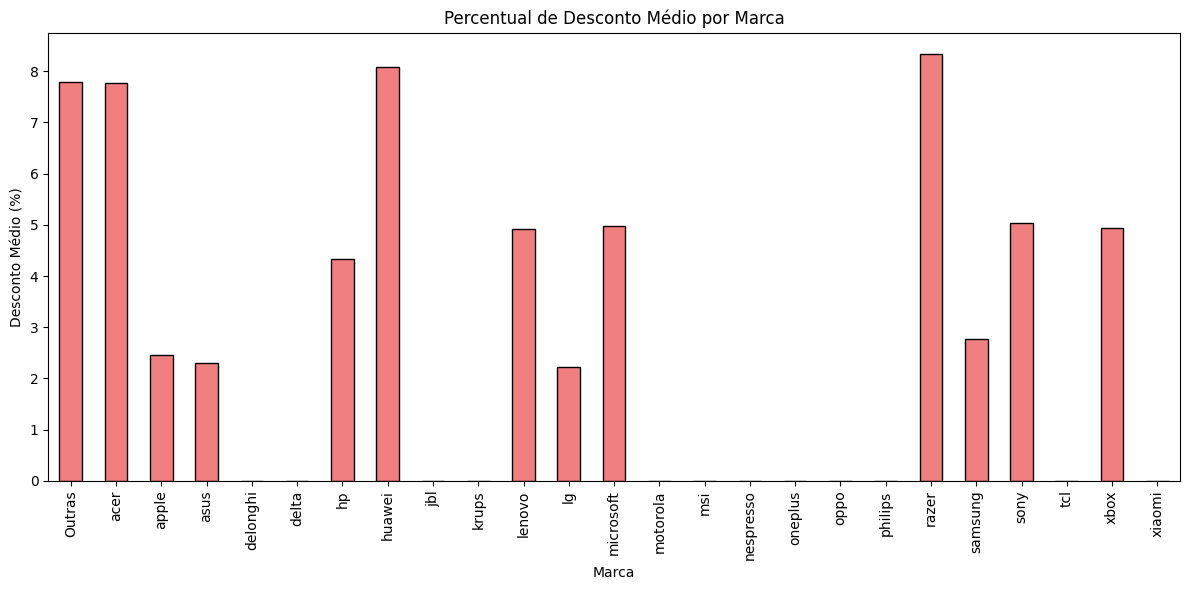

NameError: name 'sns' is not defined

<Figure size 1500x1000 with 0 Axes>

In [ ]:

class ProductVisualizer:
    def __init__(self, df_analyzed, insights):
        self.df = df_analyzed
        self.insights = insights
        self.analyser = ProductAnalyzer()
    
    def plot_category_distribution(self):
        """Distribuição de produtos por categoria"""
        plt.figure(figsize=(12, 6))
        category_counts = self.insights['by_category']['total_products']
        category_counts = category_counts.reset_index()
        category_counts.columns = ['categoria', 'total_products']
        fig = px.bar(
            category_counts.reset_index(),
            x='categoria',
            y='total_products',
            title='Distribuição de Produtos por Categoria',
            labels={'categoria': 'Categoria', 'total_products': 'Número de Produtos'},
            color='categoria'
        )
        fig.update_layout(
            xaxis_title='Categoria',
            yaxis_title='Número de Produtos',
            legend_title='Categoria'
        )
        fig.show()
    
    def plot_brand_market_share(self):
        """Market share por categoria"""
        brand_distribution = self.insights['by_category']['brand_distribution']
        
        fig = px.bar(
            brand_distribution,
            title='Distribuição de Marcas por Categoria',
            labels={'value': 'Número de Produtos', 'index': 'Categoria'},
            barmode='stack'
        )
        fig.update_layout(
            xaxis_title='Categoria',
            yaxis_title='Número de Produtos',
            legend_title='Marca'
        )
        fig.show()
    
    def plot_price_comparison(self):
        """Comparação de preços por marca e categoria"""
        avg_prices = self.insights['by_brand']['avg_price_by_category']
        
        fig = px.bar(
            avg_prices.unstack(),
            title='Preço Médio por Marca e Categoria',
            labels={'value': 'Preço Médio', 'index': 'Categoria - Marca'},
            barmode='group'
        )
        fig.update_layout(
            xaxis_title='Categoria - Marca',
            yaxis_title='Preço Médio',
            legend_title='Marca'
        )
        fig.show()

    def plot_discount_analysis(self):
        """analise de descontos por marca"""
        discount_comparison = self.insights['by_brand']['discount_comparison']
        
        plt.figure(figsize=(12, 6))
        discount_comparison.plot(kind='bar', color='lightcoral', edgecolor='black')
        plt.title('Percentual de Desconto Médio por Marca')
        plt.xlabel('Marca')
        plt.ylabel('Desconto Médio (%)')
        plt.tight_layout()
        plt.show()
    
    def plot_site_brand_presence(self):
        """presenca de marcas por site"""
        site_presence = self.insights['by_brand']['site_presence']
        
        plt.figure(figsize=(15, 10))
        sns.heatmap(site_presence, annot=True, cmap='YlGnBu', fmt='d', linewidths=0.5)
        plt.title('Presença de Marcas por Site')
        plt.xlabel('Site')
        plt.ylabel('Marca')
        plt.tight_layout()
        plt.show()

    def plot_site_colors_presence(self):
        """Comparação entre sites de cores de iPhone e Galaxy S"""
        iphone_colors = self.insights['by_iphone_colors_by_site']
        galaxyS_colors = self.insights['by_galaxyS_colors_by_site']
        
        combined_colors = pd.concat([
            iphone_colors.assign(brand='iPhone', num_colors=iphone_colors['num_iphone_colors']),
            galaxyS_colors.assign(brand='Galaxy S', num_colors=galaxyS_colors['num_galaxyS_colors'])
        ])
        
        fig = px.bar(
            combined_colors,
            x='site',
            y='num_colors',
            color='brand',
            barmode='group',
            title='Número de Cores Disponíveis por Site para iPhone e Galaxy S',
            labels={'num_colors': 'Número de Cores', 'site': 'Site', 'brand': 'Marca'},
            category_orders={'brand': ['iPhone', 'Galaxy S']}  # Ordem das barras (opcional)
        )
        
        fig.show()

    def plot_model_series_distribution_iphone8(self):
        """distribuicao do numero de produtos por modelo"""
        model_distribution = self.insights['by_model']
        model_distribution = model_distribution['total_products']
        
        fig = px.bar(
            model_distribution,
            title='Distribuição de Numero de Produtos por Modelo',
            labels={'value': 'Número de Produtos', 'index': 'Preço'},
            barmode='group'
        )
        fig.update_layout(
            xaxis_title='Preço',
            yaxis_title='Número de Produtos',
            legend_title='Marca'
        )
        fig.show()
        
    def analyze_temporal_for_product(self, brand, brand_model, hdd, color, site):
        """
         analise temporal de preços mínimos para um produto e site especifico.
        """
        filtered_df = df_analyzed[
            (df_analyzed['brand'].str.contains(brand, case=False, na=False)) & 
            (df_analyzed['brand_model'].str.contains(brand_model, case=False, na=False)) &
            (df_analyzed['site'].str.contains(site, case=False, na=False)) &
            ((df_analyzed['HDD_size'] == hdd) | (pd.isna(df_analyzed['HDD_size']) & (hdd is None))) &
            
            ((df_analyzed['color'].str.contains(color, case=False, na=False)) if color else True)
       
        ]
        
        if filtered_df.empty:
            return None, "Nenhum dado encontrado para o produto e site especificados."
        
        try:
            temporal_data, summary = self.analyser.compare_temporal_analysis(filtered_df)
        except ValueError as e:
            return None, str(e)
        
        fig = px.line(
            temporal_data,
            x='date',
            y='min_price',
            color='brand_model',
            title=f"Preço Mínimo ao Longo do Tempo: {brand} {brand_model} {hdd} {color} - {site}",
            labels={'date': 'Data', 'min_price': 'Preço Mínimo (€)', 'brand_model': 'Produto'}
        )
        
        fig.update_layout(
            xaxis_title='Data',
            yaxis_title='Preço Mínimo (€)',
            legend_title='Produto',
            hovermode='x unified'
        )
        
        fig.show()

    def analyze_temporal_for_set_of_products(self, dict_of_products):
        """
        Analise temporal ao um conjunto de produtos
        """

        all_temporal_data = []

        for product_id, product_params in dict_of_products.items():
            print(product_id, product_params)
            brand = product_params.get('brand')
            brand_model = product_params.get('brand_model')
            hdd = product_params.get('hdd')
            color = product_params.get('color')
            site = product_params.get('site')
            print(brand, brand_model, hdd, color, site)
            filtered_df = df_analyzed[
                (df_analyzed['brand'].str.contains(brand, case=False, na=False)) & 
                (df_analyzed['brand_model'].str.contains(brand_model, case=False, na=False)) &
                (df_analyzed['site'].str.contains(site, case=False, na=False))
            ]

            if hdd is not None:
                filtered_df = filtered_df[filtered_df['HDD_size'] == hdd]

            if color is not None:
                filtered_df = filtered_df[filtered_df['color'].str.contains(color, case=False, na=False)]

            if not filtered_df.empty:
                try:
                    temporal_data, summary = self.analyser.compare_temporal_analysis(filtered_df)
                    temporal_data['product_id'] = product_id  # Adiciona o identificador do produto
                    all_temporal_data.append(temporal_data)
                except ValueError as e:
                    continue  

        if not all_temporal_data:
            return None, "Nenhum dado encontrado para os produtos e sites especificados."

        all_temporal_data_df = pd.concat(all_temporal_data)

        fig = px.line(
            all_temporal_data_df,
            x='date',
            y='min_price',
            color='product_id',
            title="Preço Mínimo ao Longo do Tempo para os Produtos",
            labels={'date': 'Data', 'min_price': 'Preço Mínimo (€)', 'product_id': 'Produto'}
        )
        
        fig.update_layout(
            xaxis_title='Data',
            yaxis_title='Preço Mínimo (€)',
            legend_title='Produto',
            hovermode='x unified'
        )
        
        fig.show()

        
        

    def analyze_discount_distribution(self):
        """
        Analisa a distribuição de preços em faixas de desconto.
        """
        bins = [0, 10, 20, 30, 40, 50, 100]
        labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50%+']
        df_analyzed['discount_range'] = pd.cut(df_analyzed['discount_percent'], bins=bins, labels=labels)
        
        discount_distribution = df_analyzed['discount_range'].value_counts().sort_index()
        
        plt.figure(figsize=(10, 6))
        discount_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title("Distribuição de Produtos por Faixa de Desconto")
        plt.xlabel("Faixa de Desconto (%)")
        plt.ylabel("Quantidade de Produtos")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
        return discount_distribution
    
    def compare_temporal_by_category(self):
        """
        comparacao temporal dos precos por categoria
        """
        temporal_data = df_analyzed.groupby(['categoria', 'date']).agg({
            'min_price': 'mean'
        }).reset_index()
        
        temporal_data['date'] = pd.to_datetime(temporal_data['date'], format='%Y%m%d')
        
        fig = px.line(
            temporal_data,
            x='date',
            y='min_price',
            color='categoria',
            title="Média de Preços por Categorias ao Longo do Tempo",
            labels={'date': 'Data', 'min_price': 'Preço Médio (€)', 'categoria': 'Categoria'}
        )
        
        fig.update_layout(
            xaxis_title='Data',
            yaxis_title='Preço Médio (€)',
            legend_title='Categoria',
            hovermode='x unified'
        )
        
        fig.show()
        


    def analyze_price_range(_df_analyzed, price_min, price_max):
        """
        Realiza análise de produtos em uma faixa de preço específica.
        """
        filtered_df = df_analyzed[(df_analyzed['min_price'] >= price_min) & (df_analyzed['min_price'] <= price_max)]
        
        if filtered_df.empty:
            return f"Nenhum produto encontrado na faixa de preço €{price_min} - €{price_max}."
        
        cheapest_product = filtered_df.loc[filtered_df['min_price'].idxmin()]
        most_expensive_product = filtered_df.loc[filtered_df['min_price'].idxmax()]
        
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df['min_price'], bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Distribuição de Preços na Faixa: €{price_min} - €{price_max}")
        plt.xlabel("Preço (€)")
        plt.ylabel("Quantidade de Produtos")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
        return {
            "cheapest_product": cheapest_product,
            "most_expensive_product": most_expensive_product
        }



df = pd.read_csv("all_prices_extracted_cleaned_categorized.csv")
analyzer = ProductAnalyzer()
df_analyzed, insights = analyzer.analyze_dataset(df)

visualizer = ProductVisualizer(df_analyzed, insights)

visualizer.plot_category_distribution()
visualizer.plot_brand_market_share()
visualizer.plot_price_comparison()
visualizer.plot_discount_analysis()
visualizer.plot_site_brand_presence()
visualizer.plot_model_series_distribution_iphone8()
visualizer.analyze_temporal_for_product("apple","iphone 8", 64.0,"prateado","fnac")
visualizer.analyze_temporal_for_set_of_products({
    'iphone_8 - fnac': {'brand': 'apple', 'brand_model': 'iphone 8', 'hdd': 64.0, 'color': 'prateado', 'site': 'fnac'},
    'galaxy_s8 - fnac': {'brand': 'samsung', 'brand_model': 'galaxy_s 8', 'hdd': 64.0, 'color': 'azul', 'site': 'fnac'},
    'huawei_p20 - elcorteingles' : {'brand': 'huawei', 'brand_model': 'p 20', 'hdd': 128.0, 'color': 'preto', 'site': 'elcorteingles'}
})
visualizer.analyze_discount_distribution()
visualizer.compare_temporal_by_category()
visualizer.analyze_price_range(500, 800)





In [ ]:
# quero fazer um grafo do site, por marca, por modelo, por cor, por tamanho de disco, por tamanho de RAM, pode ser com algum modelo
def plot_graph(df):
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = ["site", "marca", "modelo", "cor", "tamanho disco", "tamanho RAM"],
          color = "blue"
        ),
        link = dict(
          source = [0, 0, 0, 0, 0],
          target = [1, 2, 3, 4, 5],
          value = [df['site'].nunique(), df['brand'].nunique(), df['brand_model'].nunique(), df['color'].nunique(), df['HDD_size'].nunique()]
      ))])

    fig.update_layout(title_text="Sankey Diagram", font_size=10)
    fig.show()

In [ ]:
plot_graph(df_analyzed)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed